# __Importerar bibliotek__

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC


# __Hämtar MNIST-data__

In [76]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
print (mnist.DESCR)

X = mnist["data"].astype("float32")
y = mnist["target"].astype(int)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

# __Preprocessing/Förbehandling__

In [94]:
# Delar upp i train, validation, test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42, stratify=y)  # stratify - att varje siffra (0–9) får ungefär samma andel i varje låda.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42, stratify=y_train_val)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (50000, 784) (10000, 784) (10000, 784)


# __EDA__

Dataset med siffror, svarta bakgrunder. Jämnt fördelat i antal bilder per siffra mellan 0-9.


Träning - antal per siffra: 
0: 4931 (9.9%)
1: 5627 (11.3%)
2: 4992 (10.0%)
3: 5101 (10.2%)
4: 4874 (9.7%)
5: 4509 (9.0%)
6: 4912 (9.8%)
7: 5209 (10.4%)
8: 4875 (9.8%)
9: 4970 (9.9%)

Validering - antal per siffra: 
0: 986 (9.9%)
1: 1125 (11.2%)
2: 999 (10.0%)
3: 1020 (10.2%)
4: 975 (9.8%)
5: 902 (9.0%)
6: 982 (9.8%)
7: 1042 (10.4%)
8: 975 (9.8%)
9: 994 (9.9%)


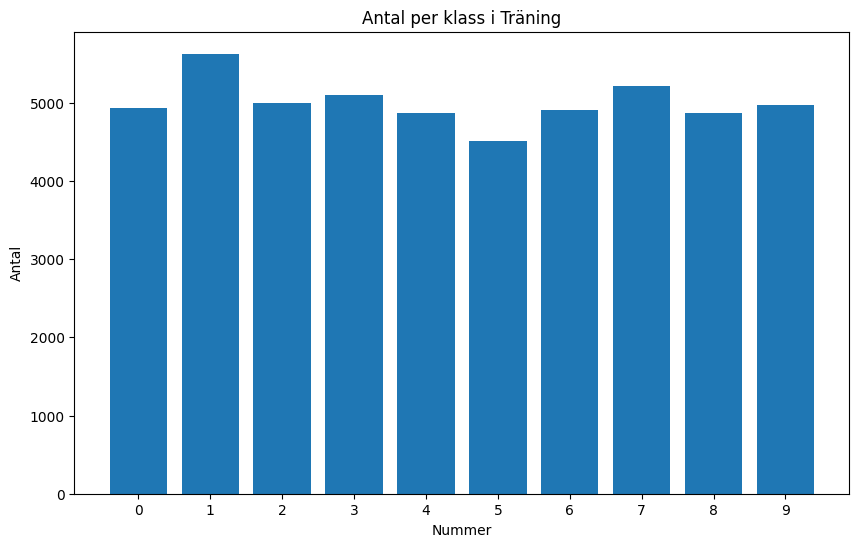

In [78]:
# Visar fördelning av klasser, antal per siffra på train- och val-data. Ser ut att vara balanserat.

def class_summary(y, name): 
    counts = np.bincount(y, minlength=10)
    total = counts.sum()
    pct = counts / total * 100
    print(f"\n{name} - antal per siffra: ")
    for digit in range(10): 
        print(f"{digit}: {counts[digit]} ({pct[digit]:.1f}%)")

class_summary(y_train, "Träning")
class_summary(y_val, "Validering")

counts_train = np.bincount(y_train, minlength=10)

plt.figure(figsize=(10, 6))
plt.bar(range(10), counts_train)
plt.xticks(range(10))
plt.title("Antal per klass i Träning")
plt.xlabel("Nummer")
plt.ylabel("Antal")
plt.show()

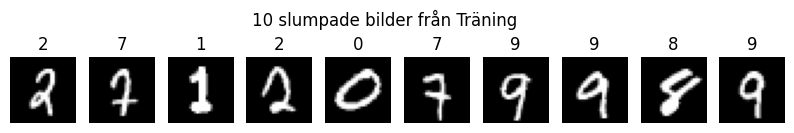

In [79]:
# Visar ut slumpade siffror för att undersöka hur datasetet ser ut på träningsdata. 

random_numbers = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(10, 2))
for i, j in enumerate(random_numbers, 1):
    plt.subplot(1, 10, i)
    plt.imshow(X_train[j].reshape(28, 28), cmap="grey")
    plt.title(str(y_train[j]))
    plt.axis("off")
plt.suptitle("10 slumpade bilder från Träning", y=0.9)
plt.show()

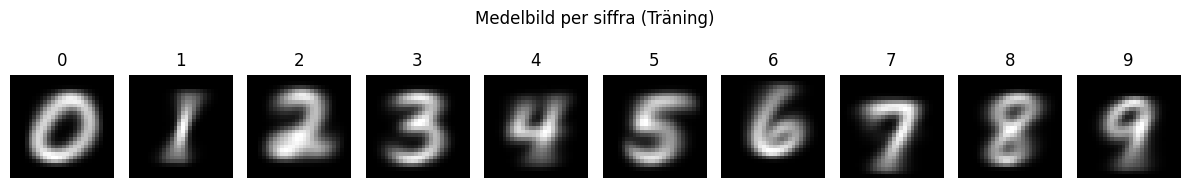

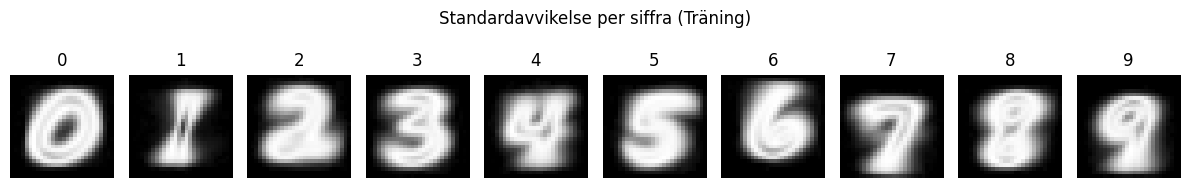

In [80]:
# Visar ut medelbild (typisk form för varje siffra) och standardavvikelse (hur mycket pixlarna varierar inom samma siffra) för att förstå datasetets mönster och var variationen är störst, vilket kan vara extra svårt för modeller att lära sig

def plot_per_digit_images(X, y, agg="mean", title=""):
    plt.figure(figsize=(12, 2))
    for digit in range(10):
        data = X[y == digit]
        img = getattr(data, agg)(axis=0).reshape(28, 28)

        plt.subplot(1, 10, digit + 1)
        plt.imshow(img, cmap="gray")
        plt.title(digit)
        plt.axis("off")

    plt.suptitle(title, y=1)
    plt.tight_layout()
    plt.show()

plot_per_digit_images(X_train, y_train, agg="mean", title="Medelbild per siffra (Träning)")
plot_per_digit_images(X_train, y_train, agg="std",  title="Standardavvikelse per siffra (Träning)")


# __Modellträning__

------------------------------------------------------------------------------------------------------------------------------------
#### __LogisticRegression__
- LogisticRegression utan GridSearchCV: VAL accuracy: 0.9166
- LogisticRegression med GridSearchCV: Bästa C: {'model__C': 0.01}, Bästa CV-accuracy: 0.92086, VAL accuracy (best): 0.9269
__Slutsats:__ Låg accuracy, 0,917-0,927, finns modeller som presterar bättre, lägger inte mer tid på denna. 

VAL accuracy (best): 0.9166


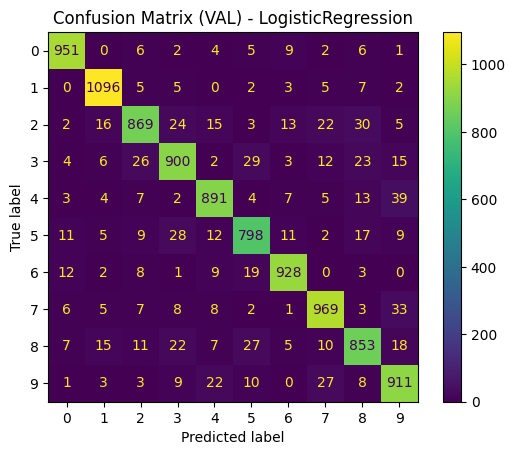

In [81]:
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=4000, solver="lbfgs"))
])

pipe_lr.fit(X_train, y_train)

y_val_pred_lr = pipe_lr.predict(X_val)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr) 
print("Validering accuracy:", val_acc_lr)

cm_lr = confusion_matrix(y_val, y_val_pred_lr)
ConfusionMatrixDisplay(cm_lr).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - LogisticRegression")
plt.show()

Bästa C: {'model__C': 0.01}
Bästa CV-accuracy: 0.92086
Validering accuracy: 0.9269


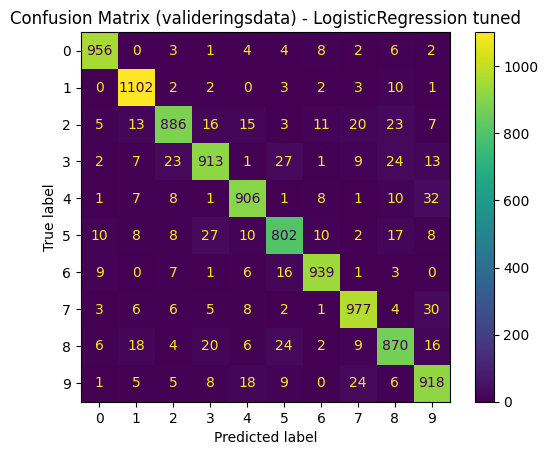

In [82]:
pipe_lr_gs = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=4000, solver="lbfgs"))
])

hyperparam_grid_lr = {
    "model__C": [0.01, 0.05, 0.1, 0.2]
}

gs_lr = GridSearchCV(
    estimator=pipe_lr_gs,
    param_grid=hyperparam_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)

print("Bästa C:", gs_lr.best_params_)
print("Bästa CV-accuracy:", gs_lr.best_score_)

best_model = gs_lr.best_estimator_

# VAL-utvärdering
y_val_pred_lr_gs = best_model.predict(X_val)
val_acc_lr_gs = accuracy_score(y_val, y_val_pred_lr_gs)
print("Validering accuracy:", val_acc_lr_gs)

cm_lr_gs = confusion_matrix(y_val, y_val_pred_lr_gs)
ConfusionMatrixDisplay(cm_lr_gs).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - LogisticRegression tuned")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
#### __RandomForest__
- RandomForest utan GridSearchCV: __VAL accuracy = 0.9724__
- RandomForest med GridSearchCV (bästa params: max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500): __VAL accuracy = 0.9697__

__Slutsats:__ Hyperparametrar för RandomForest otptimerades med GridSearchCV på ett slumpmässigt subset av träningsdatan för att klara av beräkningen på laptop. I mina tester gav RandomForest med standardinställningar högst VAL accuracy, både med och utan optimering av hyperparameteroptimering. Ingen tydlig förbättring med tuning av hyperparametrar. Det tyder på att standardparametrar redan är bra för detta dataset, att ytterligare tuning ger begränsad effekt i förhållande till den ökade beräkningskostnaden (upplevde att det tog mycket mer kapacitet från datorn vid tuning jämfört med standardvärden).

Validering accuracy: 0.9724


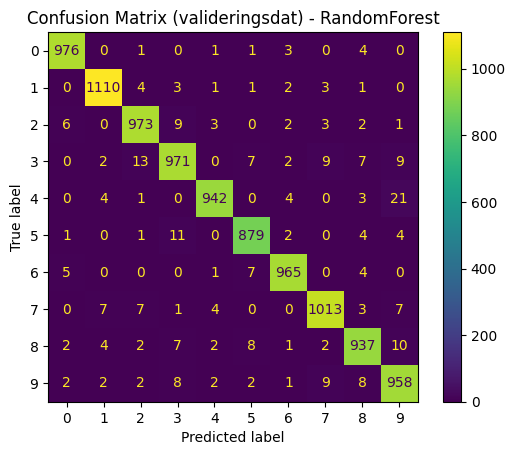

In [83]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)
print("Validering accuracy:", val_acc_rf)

cm_rf = confusion_matrix(y_val, y_val_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdat) - RandomForest")
plt.show()

Subset counts: [1972 2251 1997 2040 1949 1804 1965 2084 1950 1988]
Subset %: [ 9.86 11.26  9.98 10.2   9.74  9.02  9.83 10.42  9.75  9.94]
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Bästa RF params (subset): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Bästa RF CV-accuracy (subset): 0.9561001922901154

Validering accuracy: 0.9697


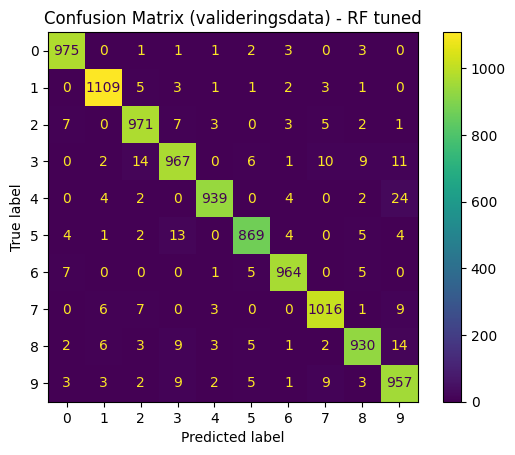

In [84]:
subset_size = min(20000, X_train.shape[0]) 
sss = StratifiedShuffleSplit(n_splits=1, train_size=subset_size, random_state=42)
subset_rows, _ = next(sss.split(X_train, y_train))

# Stratifierat subset (bevarar klassfördelning) för snabbare GridSearch på laptop
X_train_sub = X_train[subset_rows] 
y_train_sub = y_train[subset_rows] 

# Visar ut att jag har ca 10% per siffra, bra inför träning av modellen
counts = np.bincount(y_train_sub, minlength=10)
print("Subset counts:", counts)
print("Subset %:", (counts / counts.sum() * 100).round(2))

pipe_rf_gs = RandomForestClassifier( 
    random_state=42, 
    n_jobs=1, 
    bootstrap=True
) 

# Hyperparameter-sökning på subset för att snabbare hitta rimliga inställningar för hyperparametrarna
hyperparam_grid_rf = { 
    "n_estimators": [300, 500], 
    "max_depth": [20, 30], 
    "max_features": ["sqrt"], 
    "min_samples_leaf": [1], 
    "min_samples_split": [2] 
} 

gs_rf = GridSearchCV( 
    estimator=pipe_rf_gs, 
    param_grid=hyperparam_grid_rf, 
    cv=3, 
    scoring="accuracy", 
    n_jobs=2, 
    verbose=2 
) 

gs_rf.fit(X_train_sub, y_train_sub) 

print("\nBästa RF params (subset):", gs_rf.best_params_) 
print("Bästa RF CV-accuracy (subset):", gs_rf.best_score_) 

# Tränar om modell på hela träningsdatan med bästa parametrar från subset-sökningen
best_params_gs_rf = gs_rf.best_params_ 

rf_gs_full = RandomForestClassifier( 
    random_state=42, 
    max_samples=0.8,
    n_jobs=1, 
    bootstrap=True, 
    **best_params_gs_rf
) 

rf_gs_full.fit(X_train, y_train) 

y_val_pred_rf_gs = rf_gs_full.predict(X_val) 
val_acc_rf_gs = accuracy_score(y_val, y_val_pred_rf_gs) 
print("\nValidering accuracy:", val_acc_rf_gs) 

cm_rf_gs = confusion_matrix(y_val, y_val_pred_rf_gs) 
ConfusionMatrixDisplay(cm_rf_gs).plot(values_format="d") 
plt.title("Confusion Matrix (valideringsdata) - RF tuned") 
plt.show()

Validering accuracy: 0.9697


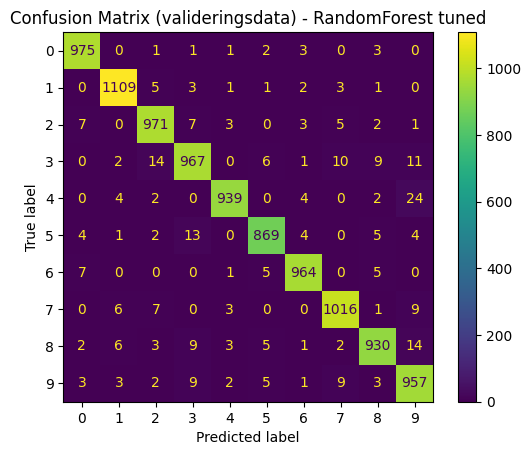

In [85]:
# Slutgiltigt test: tränar RandomForest med de bästa hyperparametrarna från föregående tuning (samma resultat eftersom jag använder samma hyperparametrar men snabbare träning av modellen).
rf_final = RandomForestClassifier(
    random_state=42,
    n_jobs=1,
    bootstrap=True,
    max_samples=0.8,
    n_estimators=500,
    max_depth=20,
    max_features="sqrt",
    min_samples_leaf=1,
    min_samples_split=2
)

rf_final.fit(X_train, y_train)

y_val_pred_rf_f = rf_final.predict(X_val)
val_acc_rf_f = accuracy_score(y_val, y_val_pred_rf_f)
print("Validering accuracy:", val_acc_rf_f)

cm_rf_f = confusion_matrix(y_val, y_val_pred_rf_f, labels=np.arange(10))
ConfusionMatrixDisplay(cm_rf_f, display_labels=np.arange(10)).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - RandomForest tuned")
plt.show()


------------------------------------------------------------------------------------------------------------------------------------
### LinearSVC
- LinearSVC (med C=1.0, max_iter=6000, tol=1e-3,dual="auto")): __VAL accuracy = 0.9137__

__Slutsats:__  LinearSVC tar alldeles för mycket lång tid och ger för dåligt resultat (låg acuracy) för att jag ska välja att gå vidare med modellen. 

Validering accuracy: 0.9137


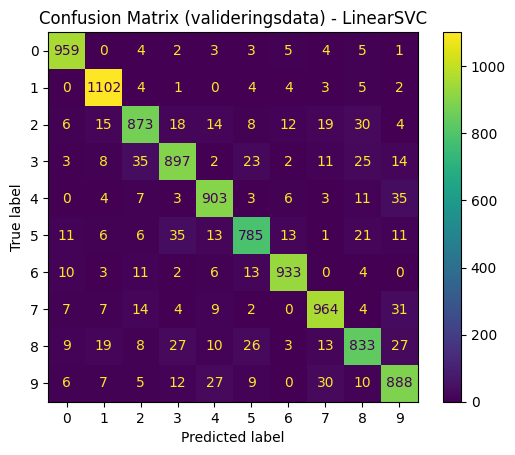

In [86]:
pipe_lsvc = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearSVC(C=1.0, max_iter=6000, tol=1e-3,dual="auto", random_state=42)) # har fått optimera bort tol=1e-3, dual="auto", minskat max_iter för att få modellen att köra klart inom rimlig tid. Testat mer bredd men tar då över 1h att köra och det hinner inte ens gå klart på min laptop. 
])

pipe_lsvc.fit(X_train, y_train)

y_val_pred_lsvc = pipe_lsvc.predict(X_val)
val_acc_lsvc = accuracy_score(y_val, y_val_pred_lsvc)
print("Validering accuracy:", val_acc_lsvc)

cm_lsvc = confusion_matrix(y_val, y_val_pred_lsvc)
ConfusionMatrixDisplay(cm_lsvc).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - LinearSVC")
plt.show()

------------------------------------------------------------------------------------------------------------------------------------
#### __SVC__
- SVC (RBF), default (C=1.0, gamma=scale), utan PCA och utan GridSearch:: __VAL accuracy (SVC): 0.9656__
- SVC med GridSearchCV (stegvis tuning av C, gamma och PCA): VAL accuracy (SVC tuned): ~0.9795–0.9796 (Bästa parametrar: PCA=75, gamma="scale", C=14): __VAL accuracy (SVC): 0.9795__

__Slutsats:__  SVC med RBF-kärna presterade stabilt och gav hög VAL-accuracy runt 0,9795. GridSearchCV gav bara en marginell förbättring jämfört med en rimlig standardinställning, och den bästa modellen blev PCA=75 + gamma="scale" + C=14. Med hänsyn till begränsade resurser på laptop avgränsades sökutrymmet, men resultaten var konsekventa över flera tester. 

Validering accuracy: 0.9656


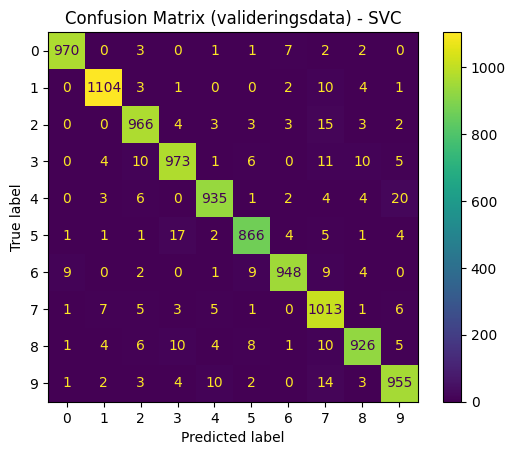

In [87]:
pipe_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC())
])

pipe_svc.fit(X_train, y_train)

y_val_pred_svc = pipe_svc.predict(X_val)
val_acc_svc = accuracy_score(y_val, y_val_pred_svc)
print("Validering accuracy:", val_acc_svc)

cm_svc = confusion_matrix(y_val, y_val_pred_svc)
ConfusionMatrixDisplay(cm_svc).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - SVC")
plt.show()


##### Tränar modell för att få fram bästa PCA med GridSearchCV (kör i olika steg i och med prestandabegränsningar i laptop).

In [88]:
pipe_svc_gs_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=42)),
    ("model", SVC(kernel="rbf", C=10, gamma="scale", cache_size=2000))
])

hyperparams_grid_svc_pca = {
    "pca__n_components": [75, 76]
}

gs_svc_pca = GridSearchCV(
    estimator=pipe_svc_gs_pca,
    param_grid=hyperparams_grid_svc_pca,
    cv=3,
    scoring="accuracy",
    n_jobs=2,
    pre_dispatch=2,
    verbose=2,
    return_train_score=False
)

gs_svc_pca.fit(X_train, y_train)

BEST_PCA = gs_svc_pca.best_params_["pca__n_components"]
print("Bästa PCA:", BEST_PCA)
print("Bästa CV-accuracy:", gs_svc_pca.best_score_)



Fitting 3 folds for each of 2 candidates, totalling 6 fits
Bästa PCA: 75
Bästa CV-accuracy: 0.9729999087765755


##### Tränar modell för att få fram bästa gamma och C med GridSearchCV (kör i olika steg i och med prestandabegränsningar i laptop). 

Fitting 3 folds for each of 9 candidates, totalling 27 fits

Bästa params: {'model__C': 10, 'model__gamma': 'scale'}
Bästa CV-accuracy: 0.9729999087765755

Slutmodellparametrar:
PCA n_components: 75
C: 10
gamma: scale
Validering accuracy: 0.9794


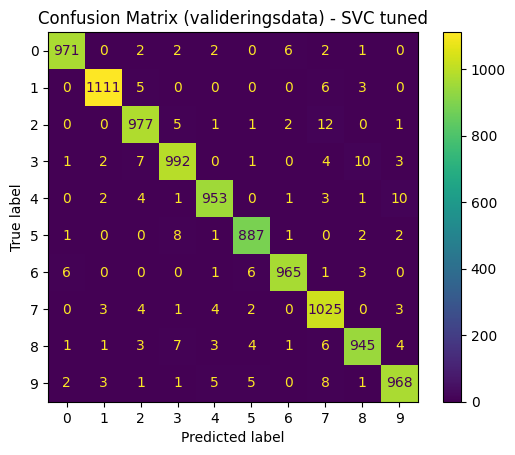

In [89]:
BEST_PCA = 75

# Hitta bästa gamma + C (med PCA låst)
pipe_svc_gs_gamma = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(BEST_PCA, random_state=42)),
    ("model", SVC(kernel="rbf", cache_size=2000))
])

hyperparams_grid_svc_gamma = {
    "model__C": [3, 10, 30],
    "model__gamma": ["scale", 0.01, 0.03]
}

gs_svc_gamma = GridSearchCV(
    estimator=pipe_svc_gs_gamma,
    param_grid=hyperparams_grid_svc_gamma,
    cv=3,
    scoring="accuracy",
    n_jobs=2,
    pre_dispatch=2,
    verbose=2,
    return_train_score=False
)

gs_svc_gamma.fit(X_train, y_train)

BEST_C = gs_svc_gamma.best_params_["model__C"]
BEST_GAMMA = gs_svc_gamma.best_params_["model__gamma"]

print("\nBästa params:", gs_svc_gamma.best_params_)
print("Bästa CV-accuracy:", gs_svc_gamma.best_score_)


svc_final_model_gamma = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=BEST_PCA, random_state=42)),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=2000))
])

svc_final_model_gamma.fit(X_train, y_train)

y_val_pred_svc_gs_gamma = svc_final_model_gamma.predict(X_val)
val_acc_svc_gs_gamma = accuracy_score(y_val, y_val_pred_svc_gs_gamma)

print("\nSlutmodellparametrar:")
print("PCA n_components:", BEST_PCA)
print("C:", BEST_C)
print("gamma:", BEST_GAMMA)
print("Validering accuracy:", val_acc_svc_gs_gamma)

cm_svc_gs_gamma = confusion_matrix(y_val, y_val_pred_svc_gs_gamma)
ConfusionMatrixDisplay(cm_svc_gs_gamma).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - SVC tuned")
plt.show()

##### Tränar modell för att få fram bästa C med GridSearchCV (kör i olika steg i och med prestandabegränsningar i laptop). 

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] END ........................................model__C=10; total time=  35.3s
[CV] END ........................................model__C=10; total time=  26.6s
[CV] END ........................................model__C=10; total time=  29.6s
[CV] END ........................................model__C=11; total time=  28.5s
[CV] END ........................................model__C=11; total time=  26.5s
[CV] END ........................................model__C=11; total time=  27.9s
[CV] END ........................................model__C=12; total time=  29.0s
[CV] END ........................................model__C=12; total time=  24.6s
[CV] END ........................................model__C=12; total time=  25.7s
[CV] END ........................................model__C=13; total time=  28.5s
[CV] END ........................................model__C=13; total time=  27.5s
[CV] END ........................................

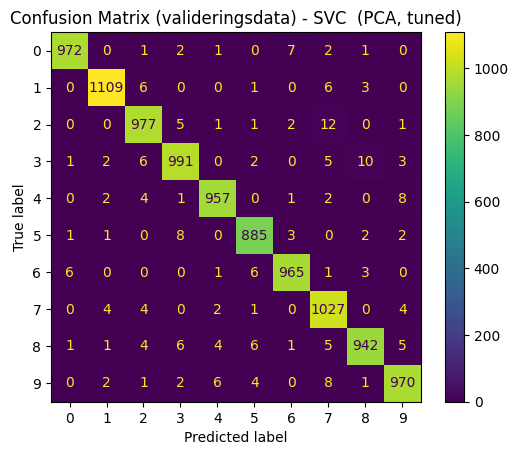

In [90]:
BEST_PCA = 75
BEST_GAMMA = "scale"

# GridSearch över (PCA och gamma låst)
pipe_svc_gs_c = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", gamma="scale", cache_size=500))
])

hyperparams_grid_svc_c = {
    "model__C": [10, 11, 12, 13, 14, 15, 16]
}

gs_svc_c = GridSearchCV(
    estimator=pipe_svc_gs_c,
    param_grid=hyperparams_grid_svc_c,
    cv=3,
    scoring="accuracy",
    n_jobs=1,
    pre_dispatch=1,
    verbose=2,
    return_train_score=False
)

gs_svc_c.fit(X_train, y_train)

BEST_C = gs_svc_c.best_params_["model__C"]

print("\nBästa params:", gs_svc_c.best_params_)
print("Bästa CV-accuracy:", gs_svc_c.best_score_)


svc_final_model_c = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=500))
])

svc_final_model_c.fit(X_train, y_train)

y_val_pred_svc_gs_c = svc_final_model_c.predict(X_val)
val_acc_svc_gs_c = accuracy_score(y_val, y_val_pred_svc_gs_c)

print("\nSlutmodellparametrar:")
print("PCA n_components:", BEST_PCA)
print("C:", BEST_C)
print("gamma:", BEST_GAMMA)
print("Validering accuracy:", val_acc_svc_gs_c)

cm_svc_gs_c = confusion_matrix(y_val, y_val_pred_svc_gs_c)
ConfusionMatrixDisplay(cm_svc_gs_c).plot(values_format="d")
plt.title("Confusion Matrix (valideringsdata) - SVC  (PCA, tuned)")
plt.show()


In [91]:
results = []
results.append(("LogisticRegression", val_acc_lr))
results.append(("LogisticRegression + GridSearchCV", val_acc_lr_gs))
results.append(("RandomForest", val_acc_rf))
results.append(("RandomForest + GridSearchCV", val_acc_rf_f))
results.append(("LinearSVC", val_acc_lsvc))
results.append(("SVC", val_acc_svc))
results.append(("SVC + GridSearchCV", val_acc_svc_gs_c))

df_results = pd.DataFrame(results, columns=["Modell", "Validering accuracy"]).sort_values("Validering accuracy", ascending=False)
print(df_results)

                              Modell  Validering accuracy
6                 SVC + GridSearchCV               0.9795
2                       RandomForest               0.9724
3        RandomForest + GridSearchCV               0.9697
5                                SVC               0.9656
1  LogisticRegression + GridSearchCV               0.9269
0                 LogisticRegression               0.9166
4                          LinearSVC               0.9137


# __Slutreultat: Final model:__ 

Jag har testat mig fram på en laptop med begränsade resurser, vilket gjorde att vissa körningar tog lång tid. Därför behövde jag begränsa antalet parametrar och kombinationer i mina tester. Efter flera dagars experiment med olika modeller, olika hyperparametrar, olika begränsningar i träning och utvärdering landade jag i följande slutmodell:

- SVC (RBF)

### __Hyperparametrar:__
- kernel = "rbf"
- gamma = "scale"
- PCA: n_components = 75
- C = 14

In [92]:
BEST_PCA = 75
BEST_C = 14
BEST_GAMMA = "scale"

print("=== FINAL hyperparams: ===")
print(f"PCA = {BEST_PCA}, C = {BEST_C}, gamma = {BEST_GAMMA}, kernel = rbf")

print(f"\nPåbörjar träning inför utvärdering mot validering och test......")

final_model_svc = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=BEST_PCA, random_state=42, svd_solver="randomized")),
    ("model", SVC(kernel="rbf", C=BEST_C, gamma=BEST_GAMMA, cache_size=500))
])

# Tränar på träningsdata
final_model_svc.fit(X_train, y_train)

# Utvärderar validering och testdata
y_val_pred_final  = final_model_svc.predict(X_val)
y_test_pred_final = final_model_svc.predict(X_test)

val_acc = accuracy_score(y_val, y_val_pred_final)
test_acc = accuracy_score(y_test, y_test_pred_final)

print("\n=== Resultat ===")
print("Validering accuracy:", val_acc)
print("Test accuracy:", test_acc)

=== FINAL hyperparams: ===
PCA = 75, C = 14, gamma = scale, kernel = rbf

Påbörjar träning inför utvärdering mot validering och test......

=== Resultat ===
Validering accuracy: 0.9795
Test accuracy: 0.9768


## Analys av felklassificeringar (TEST) 
Nedan ser vi hur väl vald modell presterat. Visar ut accuracy på valideringsdata och testdata. På testdata blir det minimalt sämre resultat vilket tyder på att modellen kommer att klara sig bra på ny osedd data. 
Jag visar också ut hur väl modellen predikterar olika siffror. Den gör minimalt med fel utifrån totalt antal bilder, men visar sämst på 9:or och bäst på 0:or. 
På dom felklassificerade bilderna ser man att det är siffror som kan vara svåra att tolka även för en människa (t.ex. brus, ofullständiga streck eller otydliga skrivstilar). Det skulle säkert gå att göra modellen lite vassare för att hitta fler av dessa feltolkade siffror korrekt. Dock väljer jag ändå att gå vidare med min valda modell när jag ska skapa min app i Streamlit. Den är ändå good-enough!

=== Analys av final model: SVC (med tuning) ===

=== Valideringsdata ===
Antal fel: 205 av 10000
Accuracy: 0.9795


=== Testdata ===
Antal fel: 232 av 10000
Accuracy: 0.9768


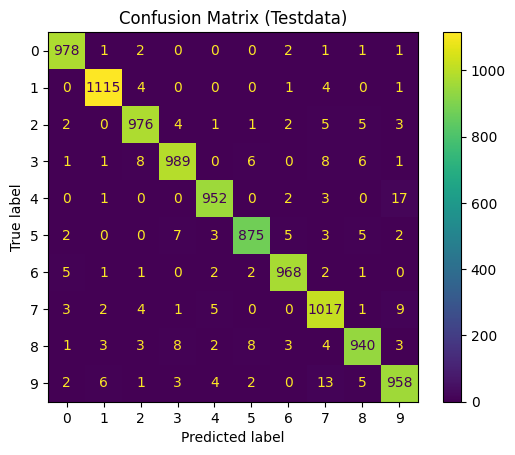

=== Testdata ===
   Siffra (sann)  Antal  Fel  Fel%  Recall%
0              9    994   36  3.62    96.38
1              8    975   35  3.59    96.41
2              3   1020   31  3.04    96.96
3              5    902   27  2.99    97.01
4              7   1042   25  2.40    97.60
5              4    975   23  2.36    97.64
6              2    999   23  2.30    97.70
7              6    982   14  1.43    98.57
8              1   1125   10  0.89    99.11
9              0    986    8  0.81    99.19


===Felklassificerade siffror, modellen predikterat felaktiga siffror===


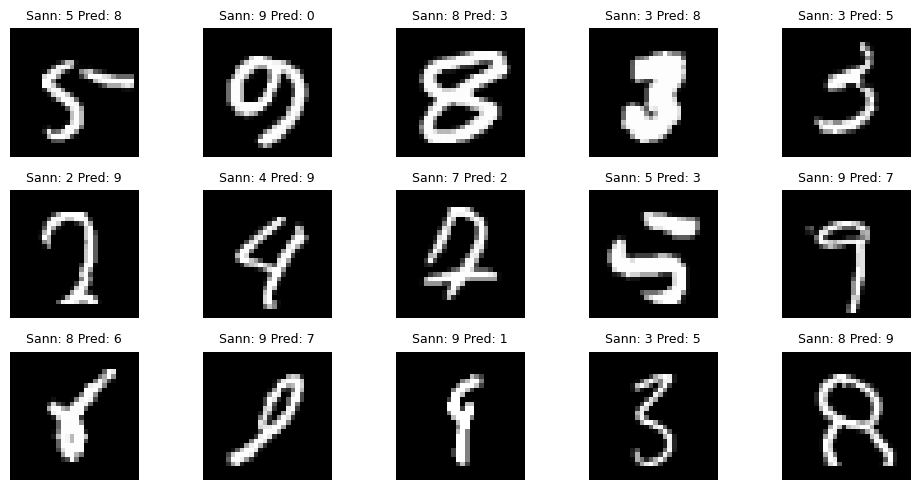

In [93]:
print(f"=== Analys av final model: SVC (med tuning) ===\n")

# Valideringsdata, antal fel
print(f"=== Valideringsdata ===")
val_wrong_numbers = np.where(y_val_pred_final != y_val)[0]
n_wrong_val = len(val_wrong_numbers)

print(f"Antal fel: {n_wrong_val} av {len(y_val)}")
print(f"Accuracy: {(len(y_val)-n_wrong_val)/len(y_val):.4f}\n\n")

#Testdata, antal fel
print(f"=== Testdata ===")
test_wrong_numbers = np.where(y_test_pred_final != y_test)[0]
n_wrong_test = len(test_wrong_numbers)

print(f"Antal fel: {n_wrong_test} av {len(y_test)}")
print(f"Accuracy: {(len(y_test)-n_wrong_test)/len(y_test):.4f}")


cm_test = confusion_matrix(y_test, y_test_pred_final, labels=np.arange(10))
ConfusionMatrixDisplay(cm_test).plot(values_format="d")
plt.title("Confusion Matrix (Testdata)")
plt.show()



def fel_per_siffra(y_true, y_pred, n_classes=10):
    """
    Returnerar en tabell med antal, antal fel, felprocent och recall per sann siffra.
    Sorterar automatiskt så sämst (högst fel%) kommer först.
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)

    count = np.bincount(y_true, minlength=n_classes)
    wrong = np.bincount(y_true[y_pred != y_true], minlength=n_classes)

    err_rate = np.divide(
        wrong, 
        count, 
        out=np.zeros(n_classes, dtype=float), 
        where=count != 0) 

    df_tabell_fel_siffra = pd.DataFrame({
        "Siffra (sann)": np.arange(n_classes),
        "Antal": count,
        "Fel": wrong,
        "Fel%": (err_rate * 100).round(2), 
        "Recall%": ((1 - err_rate) * 100).round(2)
    })

    return df_tabell_fel_siffra.sort_values("Fel%", ascending=False).reset_index(drop=True)

# Visar ut tabell med fel, fel%, recall%
print(f"=== Testdata ===")
df_fel_siffra = fel_per_siffra(y_test, y_test_pred_final)
print(df_fel_siffra)


# Bilder på felprediktioner
print(f"\n\n===Felklassificerade siffror, modellen predikterat felaktiga siffror===")
wrong_predictions = np.where(y_test_pred_final != y_test)[0]

n_show = 15
show_wrong_predictions = wrong_predictions[:n_show]

cols = 5
rows = int(np.ceil(len(show_wrong_predictions) / cols))

plt.figure(figsize=(10, 5))
for k, i in enumerate(show_wrong_predictions, start=1):
    plt.subplot(rows, cols, k)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title(f"Sann: {y_test[i]} Pred: {y_test_pred_final[i]}", fontsize=9)

plt.tight_layout()
plt.show()